In [371]:
!pip3 install numpy
!pip3 install opencv-python
!pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [372]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

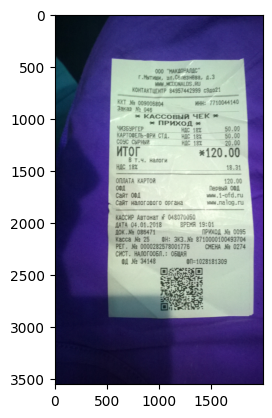

In [373]:
filename = 'TestSet1/0002.jpg'
img = cv.imread(filename)

cv.imwrite('tmp/1001.jpg', img)
plt.imshow(img)
plt.show()

In [374]:
def find_contours(img, debug=False):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY )
    img_gray = cv.bitwise_not(img_gray)

    thresh = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 11, 5)
    thresh = cv.medianBlur(thresh, 7, 7)
    contour, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    if debug:
        img_cont = img.copy()
        cv.drawContours( img_cont, contour, -1, (255,0,0), 1, cv.LINE_AA, hierarchy, 2 )
        cv.imwrite('tmp/1001.jpg', img_cont)
        plt.imshow(img_cont)
        plt.show()

    return contour, hierarchy[0, ...]


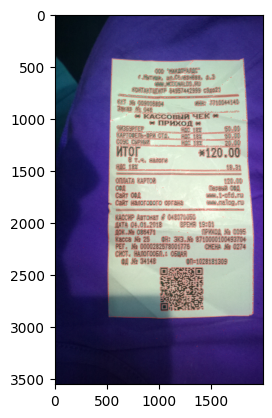

In [375]:
contours, hierarchy = find_contours(img.copy(), debug=True)

In [376]:
def find_parents(hierarchy):
    parents = []
    for hier_idx in hierarchy:
        if hier_idx[3] not in parents:
            parents.append(hier_idx[3])
    return parents

In [377]:
def is_square(width, height, thres = 0.8):
    delta = 0 # [0, 1]
    if width > height:
        delta = height / width
    else:
        delta = width / height
    return delta > thres

def fits_good(area, width, height, thres = 0.8):
    return area / (width * height) > thres

In [378]:
def get_good_contours(contours, hierarchy, parents):
    good_idx = []
    good_cnt = []
    hier = []
    for parent in parents:
        if parent == -1:
            continue
        cnt = contours[parent]
        area_cnt = cv.contourArea(cnt)
        if area_cnt < 50:
            continue

        if area_cnt > 10000:
            continue
        
        rect = cv.minAreaRect(cnt)
        width, height = rect[1]
        if not fits_good(area_cnt, width, height):
            continue

        if not is_square(width, height, 0.8):
            continue

        box = cv.boxPoints(rect)
        box = np.intp(box)
        
        good_cnt.append(cnt)
        good_idx.append(parent)
        hier.append(hierarchy[parent])
    return good_idx, good_cnt, hier

In [379]:
parents = find_parents(hierarchy)
good_idx, good_cnt, hier = get_good_contours(contours, hierarchy, parents)

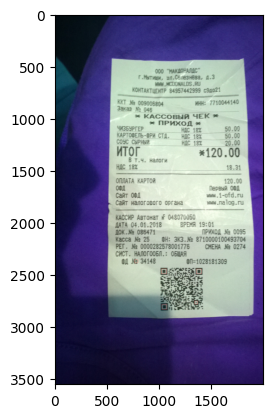

In [380]:
img_cnt = img.copy()
for idx in range(len(good_cnt)):
    cv.drawContours( img_cnt, good_cnt[idx:idx+1], -1, (255,0,0), 1, cv.LINE_AA, np.array([hier[idx:idx+1]]), 2 )
cv.imwrite('tmp/2001.jpg', img_cnt)
plt.imshow(img_cnt)
plt.show()

In [381]:
def find_qrcodes(good_idx, hier):
    qr_codes = []
    for i, idx in enumerate(good_idx):
        sons = 0
        for obj in hier:
            if obj[-1] == idx:
                sons += 1
        if sons == 3:
            qr_codes.append(i)
    return qr_codes

In [382]:
def draw_qrcodes(img, qrcodes_idx, good_cnt, hier):
    img_qrcode = img.copy()
    for qrcode_idx in qrcodes_idx:
        cv.drawContours( img_qrcode, good_cnt[qrcode_idx:qrcode_idx+1], -1, (255,0,0), 1, cv.LINE_AA, np.array([hier[qrcode_idx:qrcode_idx+1]]), 2 )

        cnt = good_cnt[qrcode_idx]
        rect = cv.minAreaRect(cnt)
        box = cv.boxPoints(rect)
        box = np.intp(box)
        cv.drawContours(img_qrcode,[box],0,(0,0,255),2)
    return img_qrcode

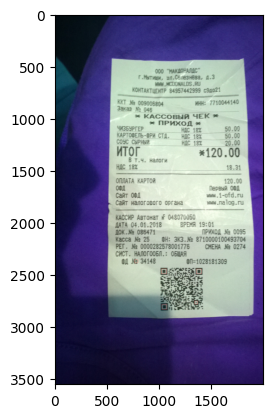

In [383]:
qrcodes_idx = find_qrcodes(good_idx, hier)
img_qrcodes = draw_qrcodes(img, qrcodes_idx, good_cnt, hier)
cv.imwrite('tmp/3001.jpg', img_qrcodes)
plt.imshow(img_cnt)
plt.show()

In [384]:
from os import path

def find_qrcode(folder, file_name):
    img_path = path.join(folder, file_name)
    img = cv.imread(img_path)
    contours, hierarchy = find_contours(img.copy(), debug=False)
    parents = find_parents(hierarchy)
    good_idx, good_cnt, hier = get_good_contours(contours, hierarchy, parents)
    qrcodes_idx = find_qrcodes(good_idx, hier)
    img_qrcodes = draw_qrcodes(img, qrcodes_idx, good_cnt, hier)
    cv.imwrite(path.join(f"{folder}Result", file_name), img_qrcodes)

In [385]:
def toFileName(idx: int):
    str_idx = str(idx)
    if len(str_idx) < 4:
        zero_num = 4 - len(str_idx)
        str_idx = "0" * zero_num + str_idx
    return str_idx + ".jpg" 

In [386]:
start = time.time()
TestSet1_sz = 48
for file in range(1, TestSet1_sz + 1):
    find_qrcode("TestSet1", toFileName(file))
end = time.time()
print("Time per one image:", (end - start) / TestSet1_sz)

[ WARN:0@68922.642] global loadsave.cpp:244 findDecoder imread_('TestSet1/0048.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'copy'

In [388]:
start = time.time()
TestSet2_sz = 48
for file in range(1, TestSet2_sz + 1):
    find_qrcode("TestSet2", toFileName(file))
end = time.time()
print("Time per one image:", (end - start) / TestSet1_sz)

Time per one image: 0.16498824954032898
